In [1]:
import pandas as pd
import numpy as np 

import geopandas as gpd
import shapely
import fiona
import folium

import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [4]:
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days/'

Importing output areas for spatial delimitation

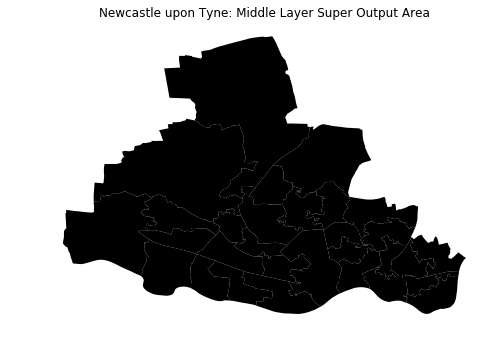

In [5]:
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
lsoa.plot(ax=axes,color='black')
plt.axis('off')
plt.title('Newcastle upon Tyne: Middle Layer Super Output Area')
plt.tight_layout()
plt.savefig(DATA_FOLDER+'plots/mlsoa_newcastle.svg', format='svg', dpi=600)

Parsing metadata positions to geopandas/shapely geometries and filtering them by output areas

In [6]:
metadata = pd.read_csv(DATA_FOLDER+'sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')

metadata.shape

(147, 5)

Concating street features to metadata

In [7]:
sfeat = pd.read_csv(DATA_FOLDER+'street_features_newcastle.csv',index_col=0)
sfeat = sfeat.loc[metadata.index]
sfeat.shape

(147, 9)

Resampling sensors samples to a specific time frequency, acquiring medians to avoid outliers, and also samples inside output area

In [8]:
sensors = pd.read_csv(DATA_FOLDER+'data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])

# resampling by freq
freq='D'
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq=freq, level=-1)]).median())

# filtering by Newcastle's region
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])

sensors.reset_index()['Sensor Name'].unique().shape

(147,)

Reducing metadata and sensors dataframes to consider less variables

In [9]:
variables = ['CO', 'Humidity', 'Journey Time', 'NO2', 'O3', 
             'PM10', 'Particle Count', 'Sound', 'Temperature', 
             'Wind Direction', 'Wind Speed']

sensors = sensors.loc[variables]
metadata = metadata.loc[sensors.index.get_level_values(1).unique()]

## 1. Feature ingestion

This consider a list of k neighbors measures for each time and variable, to predict a single target specified

In [10]:
def ingestion(sensors, metadata, sfeat, variables, k, target, method):
    idx = pd.IndexSlice
    zi = sensors.loc[target]
    zx = pd.DataFrame()
    for s in sensors.index.get_level_values(1).unique():
        i = metadata.loc[s]

        for t in sensors.index.get_level_values(2).unique():
            zkj = pd.DataFrame()
            zk = pd.DataFrame()
            zk['timestamp'] = [t]*k
            zk['zi'] = [i.name]*k
            zk['Sensor Name'] = range(0,k)
            zk.set_index(['zi','timestamp','Sensor Name'],inplace=True)

            for var in variables['sensors']:

                sdf = sensors.loc[idx[var,:,t],:] # sensors of the var variable at  time t 
                mdf = metadata.loc[sdf.index.get_level_values(1).unique()] # metadata about them

                dij = mdf['geometry'].apply(lambda x: i['geometry'].distance(x)).sort_values() # nearest measures for (var,t)
                dij = dij.loc[(dij.index!=i.name) & (dij>0)] # excluding the sensor i
                if method=='nn':
                    dij = dij[:k]
                elif method=='randomized':
                    dij = dij[:10].sample(k, random_state=0)

                zj = sdf.loc[idx[:,dij.index,:],:].reset_index([0,2])['Value']
                zj.name = var

                zj.index = range(0,k)
                dij.index = range(0,k)

                zk.loc[idx[i.name,t],'d_{}'.format(var)] = dij.values
                zk.loc[idx[i.name,t],var] = zj.values
                zkj = zk.melt().set_index('variable').T
                zkj.index = [t]
                zkj['zi'] = i.name
                zkj = zkj.reset_index().set_index(['zi','index'])
            zx = zx.append(zkj)
    if 'hour' in variables['exogenous']:
        zx['hour'] = zx.index.get_level_values(1).hour
    if 'dow' in variables['exogenous']:
        zx['dow'] = zx.index.get_level_values(1).dayofweek
    if 'day' in variables['exogenous']:
        zx['day'] = zx.index.get_level_values(1).day
    if 'month' in variables['exogenous']:
        zx['month'] = zx.index.get_level_values(1).month
    if 'year' in variables['exogenous']:
        zx['year'] = zx.index.get_level_values(1).year
      
    if 'street' in variables['exogenous']:
        try:
            zx = zx.reset_index([1]).join(sfeat).set_index('index',append=True).fillna(0)
        except:
            print('Warning: \'street\' variables are not available in metadata')
            pass

    zx = zx.loc[zi.index]
    zi = zi.loc[idx[zx.index.get_level_values(0).unique(),zx.index.get_level_values(1).unique()],:]    

    return zx, zi

In [11]:
variables = {
    'sensors':['NO2','Temperature','O3','CO','PM10'],
    'exogenous':['street','day','dow']
}

zx, zi = ingestion(sensors, metadata, sfeat, variables, k=5, target='NO2', method='randomized')
print(zx.shape,zi.shape)
zx.head()

(472, 61) (472, 1)


d_NO2     d_NO2     d_NO2     d_NO2     d_NO2  \
Sensor Name    Timestamp                                                      
aq_mesh1756150 2018-07-05  0.002386  0.003726  0.002772  0.004396  0.001956   
               2018-07-06  0.002386  0.003726  0.002772  0.004396  0.001956   
               2018-07-07  0.002386  0.003726  0.002772  0.004396  0.001956   
               2018-07-08  0.002386  0.003726  0.002772  0.004396  0.001956   
               2018-07-09  0.002386  0.003726  0.002772  0.004396  0.001956   

                                 NO2        NO2        NO2        NO2  \
Sensor Name    Timestamp                                                
aq_mesh1756150 2018-07-05  31.668412  22.350637  10.320175  35.866126   
               2018-07-06  34.312820  23.064601  26.798485  32.771639   
               2018-07-07  45.821804  32.583505  33.815808  39.980484   
               2018-07-08  31.645570  29.806548  34.748773  42.348527   
               2018-07-09  27.904558  24.049746  27.271421  32.671202   

                                 NO2    ...     day  cycleway  primary  \
Sensor Name    Timestamp                ...                              
aq_mesh1756150 2018-07-05  31.843438    ...       5         0        0   
               2018-07-06  32.373963    ...       6         0        0   
               2018-07-07  41.079689    ...       7         0        0   
               2018-07-08  46.875166    ...       8         0        0   
               2018-07-09  29.581536    ...       9         0        0   

                           secondary  service  footway  residential  \
Sensor Name    Timestamp                                              
aq_mesh1756150 2018-07-05          3        3        6            0   
               2018-07-06          3        3        6            0   
               2018-07-07          3        3        6            0   
               2018-07-08          3        3        6            0   
               2018-07-09          3        3        6            0   

                           traffic_signals  bus_stop  crossing  
Sensor Name    Timestamp                                        
aq_mesh1756150 2018-07-05                0         6         0  
               2018-07-06                0         6         0  
               2018-07-07                0         6         0  
               2018-07-08                0         6         0  
               2018-07-09                0         6         0  

[5 rows x 61 columns]

In [22]:
if False: # save
    zx.to_csv(DATA_FOLDER+'zx_D_7days.csv')
    zi.to_csv(DATA_FOLDER+'zi_D_7days.csv')
if False: # load
    zx = pd.read_csv(DATA_FOLDER+'zx_D_7days.csv',index_col=['Sensor Name','Timestamp'])
    zi = pd.read_csv(DATA_FOLDER+'zi_D_7days.csv',index_col=['Sensor Name','Timestamp'])

### 1.a. Inverse Distance Weighting

In [35]:
def iwd_features(zx, sensor_variables):
    ziwd = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        ziwd['iwd_{}'.format(var)] = (((zx['d_{}'.format(var)].values*zx[var].values).sum(axis=1))/zx['d_{}'.format(var)].values.sum(axis=1))
    return ziwd
ziwd = iwd_features(zx, variables['sensors'])
ziwd = ziwd.join(zx[zx.columns[-11:]])

if False: # save
    ziwd.to_csv(DATA_FOLDER+'zx_iwd_D_7days.csv')

### 1.b. Spatial Averaging

In [40]:
def spavg_features(zx, sensor_variables):
    zavg = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        zavg['spavg_{}'.format(var)] = zx[var].values.sum(axis=1)/zx[var].shape[1]
    return zavg   
zavg = spavg_features(zx, variables['sensors'])
zavg = zavg.join(zx[zx.columns[-11:]])

if False: # save
    zavg.to_csv(DATA_FOLDER+'zx_savg_D_7days.csv')

### 1.b. Nearest Neighbor

In [63]:
def nn_features(zx, sensor_variables):
    znn = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        znn['nn_{}'.format(var)] = zx[['d_{}'.format(var),var]].apply(lambda x: x[var].values[x['d_{}'.format(var)].values.argmin()], axis=1)
    return znn
znn = nn_features(zx, variables['sensors'])
znn = znn.join(zx[zx.columns[-11:]])

if False: # save
    znn.to_csv(DATA_FOLDER+'zx_nn_D_7days.csv')

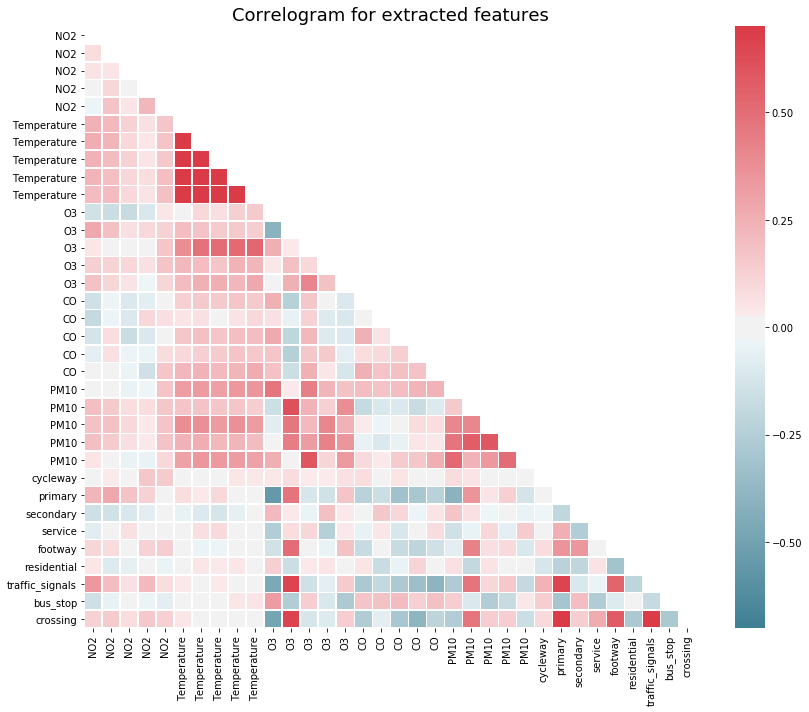

In [31]:
def corrplot(axes, zx, variables):
    corr = zx[variables].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12,10));
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, vmin=-.7,linewidths=.5, ax=axes)
    plt.title('Correlogram for extracted features', fontsize=18)
    plt.tight_layout()
    plt.savefig(DATA_FOLDER+'plots/correlogram_general.svg', format='svg', dpi=600)
corrplot(axes, zx, ['NO2','Temperature','O3','CO','PM10','cycleway','primary','secondary','service','footway','residential','traffic_signals','bus_stop','crossing'])

## Regression example

Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

paramsrf = {
    'n_estimators':np.arange(5,300,15),
    'max_features':np.arange(0.1, 1.01, 0.05),
    'max_depth':np.arange(1,20,2)
}
grid = RandomizedSearchCV(rf, param_distributions=paramsrf,
                    n_iter=1000, scoring='r2', n_jobs=-1, cv=5).fit(ziwd.values, np.ravel(zi.values))
grid.best_score_

-0.4851750737233052

MultiLayer Perceptron

In [71]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=1000)

paramsmlp = {
    'hidden_layer_sizes':[(3,1),(3,3),(3,5),(5,1),(5,3),(5,5),(10,1),(10,3),(10,5),(20,3),(20,5),(20,10)],
    'activation':['identity','relu','logistic'],
    'alpha':np.logspace(0.0001,0.1,50)
}

grid = RandomizedSearchCV(mlp, param_distributions=paramsmlp,
                    n_iter=500, scoring='r2', n_jobs=-1, cv=5).fit(zx.values, np.ravel(zi.values))
grid.best_score_

-1.0181936537185678

## Feature importance analysis

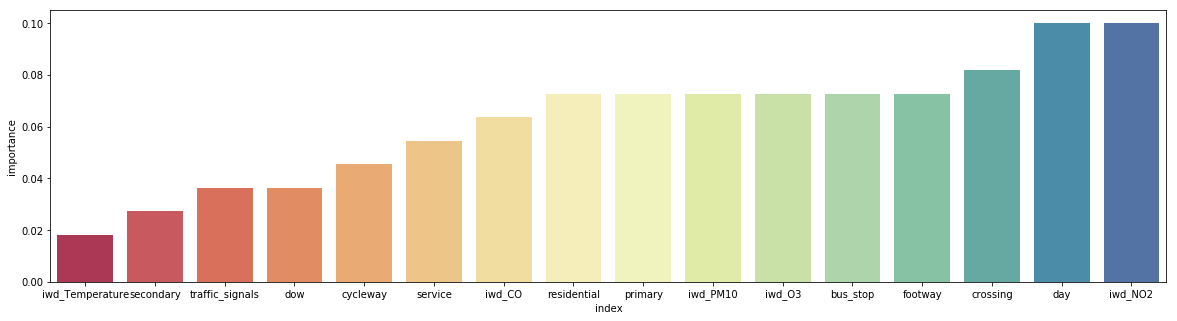

In [74]:
def featureimp_plot(grid, zx):
    importances = grid.best_estimator_.feature_importances_
    indices = zx.columns[np.argsort(importances)[::-1]]
    f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

    plt.figure(figsize=(20,5))
    return sns.barplot(x='index',y='importance',data=f, palette='Spectral')
featureimp_plot(grid,ziwd)